In [20]:
from FDD import FDD
from FDD.SURE import SURE
import numpy as np
import pandas as pd
import torch 
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
from simulations_3d import *
import matplotlib.colors as mcolors


def plot3D(X, Y, cmap = "coolwarm", alpha=0.5, s=1, eg="face", rasterize=True, tcks = [0,0.2,0.4,0.6,0.8,1], outline=False):
    
    # Create a new figure and add a 3D subplot to it
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.set_rasterized(True)

    # Scatter plot using the generated data. Color of each point is determined by its Y value
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=Y, cmap=cmap, alpha = alpha, s=s, edgecolors=eg, rasterized=rasterize, vmin=0,vmax=1)

    # Add a colorbar to the plot
    cb = fig.colorbar(scatter, orientation="horizontal", fraction=0.03, pad=0.04)
    cb.outline.set_edgecolor('lightgrey')
    cb.outline.set_visible(outline)
    cb.set_ticks(tcks)
    cb.update_ticks()


    return (fig, ax)


def getTrueFunction(jsize, resolution=0.02):
    # now sample the function values on the data points
    ymin, ymax = 0, 1
    x, y, z = np.meshgrid(np.arange(ymin, ymax, resolution), np.arange(ymin, ymax, resolution), np.arange(ymin, ymax, resolution))
    grid = np.stack((x, y, z), axis = -1)
    grid_f = np.zeros(grid.shape[:3])


    # Compute the function values on the grid
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            for k in range(grid.shape[2]):
                grid_f[i, j, k] = ft(grid[i, j, k][0], grid[i, j, k][1], grid[i, j, k][2], jsize)
    return grid, grid_f



np.random.seed(0)
import sys
old_stdout = sys.stdout

log_file = open("message.log","w")

sys.stdout = log_file

#-------------
# parameters
#-------------

sigma = 0.05
S = 32
N = 50000
#----


In [2]:

X, Y, U = generate3D(jsize = 0, sigma=sigma, N=N)
std = np.std(Y)
jsize = 0.5 * std


#u, jumps, J_grid, nrj, eps, it = model.run()

fn = '3D_SURE.pkl'

ffrom = f"'s3://ipsos-dvd/fdd/data/{fn}'"
fto = f"'/Users/davidvandijcke/Dropbox (University of Michigan)/rdd/data/out/simulations/{fn}'"
fto = fn
#!aws s3 cp $ffrom $fto --profile ipsos

with open(fto.replace("'",''), "rb") as f:
    res = pickle.load(f)

best = res.get_best_result(metric = "score", mode = "min")

config = best.metrics['config']
lmbda, nu = config['lmbda'], 0.008 # config['nu']

lmbda = 10

X, Y, U = generate3D(jsize = jsize, sigma=sigma, N=N)

N = Y.size
resolution = 1/int((N*2/3)**(1/3))
model = FDD(Y, X, level = S, lmbda = lmbda, nu = nu, iter = 100000, tol = 5e-6, resolution=resolution,
        pick_nu = "MS", scaled = True, scripted = False)

u, jumps, J_grid, nrj, eps, it = model.run()

temp = pd.DataFrame(jumps)



/home/dvdijcke/miniconda3/envs/fdd_new/lib/python3.9/site-packages/FDD/primaldual_multi_scaled_tune.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tauu = torch.tensor(  1.0 / torch.sqrt(denom) * res, device=dev)  # torch.tensor(  1.0 / 6.0 * res, device=dev) # *res
/home/dvdijcke/miniconda3/envs/fdd_new/lib/python3.9/site-packages/FDD/primaldual_multi_scaled_tune.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmap = torch.tensor( 1.0 / torch.sqrt(denom)  * res, device=dev) # torch.tensor( (1.0 / (3.0 + l))  * res, device=dev) # *res


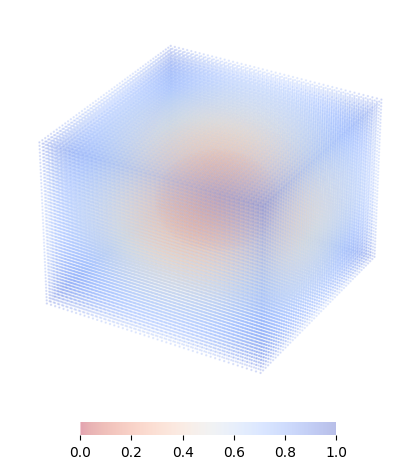

In [21]:
    

# plot underlying function
# true function
grid, grid_f = getTrueFunction(jsize,resolution=0.02)
grid_x = grid.reshape(-1, grid.shape[-1])
plot3D(grid_x, grid_f.flatten(), alpha = 0.2, s=0.5, cmap="coolwarm_r")
plt.tight_layout()
plt.margins(0)
plt.axis("off")
plt.savefig('simulation_3d_truth.pdf', bbox_inches='tight')



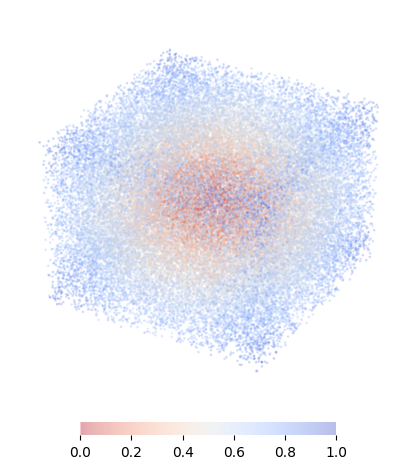

In [22]:
# plot underlying function
# noisy function

X, Y, U = generate3D(jsize = jsize, sigma=sigma, N=N)

plot3D(X, Y, alpha = 0.2, s=1, cmap="coolwarm_r")


plt.tight_layout()
plt.margins(0)
plt.axis("off")
plt.savefig('simulation_3d_pointcloud.pdf', bbox_inches='tight')

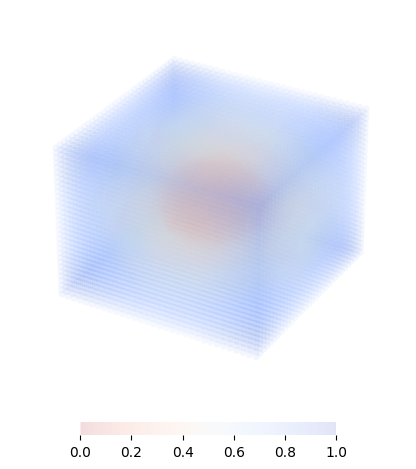

In [23]:

# plot estimated function
grid_x = model.grid_x.reshape(-1, model.grid_x.shape[-1])
plot3D(grid_x, u.flatten(), cmap = "coolwarm_r", alpha=0.075, s=25, eg="none")
plt.axis("off")
plt.tight_layout()
plt.savefig('simulation_3d_u.pdf', bbox_inches='tight')



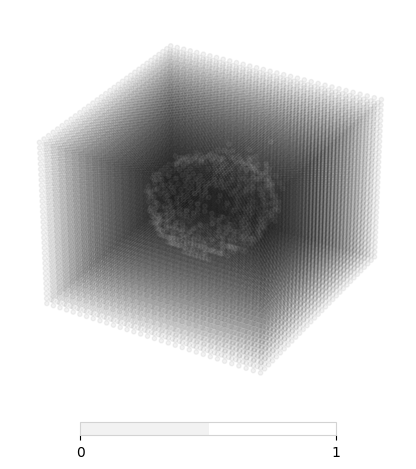

In [24]:
# plot boundary
# flatten all but last dimension of grid_x
# Define a more subtle color palette with shades of blue
colors = ["black", "white"]

# Create a colormap from the color list
cmap = mcolors.ListedColormap(colors) # mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)

plot3D(grid_x, J_grid.flatten(), cmap = cmap, alpha=0.05, s=10, eg="face", tcks=[0,1], outline = True)
plt.tight_layout()
plt.margins(0)
plt.axis("off")
plt.savefig('simulation_3d_Jgrid.pdf', bbox_inches='tight')

In [55]:
np.save("grid_x", grid_x)